#### Vivian Xia

## Assignment 2: Tree Based Models



In [ ]:
import math
import pandas as pd
import numpy as np
from operator import itemgetter

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier 

In [ ]:
sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
from google.colab import files
#uploaded = files.upload() 

df = pd.read_csv('HMEQ_Loss.csv')
print(df.head().T)

                       0        1        2     3        4
TARGET_BAD_FLAG        1        1        1     1        0
TARGET_LOSS_AMT      641     1109      767  1425      NaN
LOAN                1100     1300     1500  1500     1700
MORTDUE            25860    70053    13500   NaN    97800
VALUE              39025    68400    16700   NaN   112000
REASON           HomeImp  HomeImp  HomeImp   NaN  HomeImp
JOB                Other    Other    Other   NaN   Office
YOJ                 10.5        7        4   NaN        3
DEROG                  0        0        0   NaN        0
DELINQ                 0        2        0   NaN        0
CLAGE            94.3667  121.833  149.467   NaN  93.3333
NINQ                   1        0        1   NaN        0
CLNO                   9       14       10   NaN       14
DEBTINC              NaN      NaN      NaN   NaN      NaN


In [ ]:
#create a variable for target columns to make it easier to refer to in the future
TARGET_FLAG = 'TARGET_BAD_FLAG'
TARGET_LOSS = 'TARGET_LOSS_AMT'

## EDA and Fill in Missing Values
Simplified version of Assignment 1

In [ ]:
dt = df.dtypes

#descriptive statistics of data
x = df.describe().T 

In [ ]:
#classiify variables into list based on their datatype
objList = []
intList = []
floatList = []

for i in dt.index:
  if i in ([TARGET_FLAG, TARGET_LOSS]) : continue 
  if dt[i] in (["object"]): objList.append(i)
  if dt[i] in (["float64"]): floatList.append(i)
  if dt[i] in (["int64"]): intList.append(i)


print("-- OBJECTS --")
for i in objList:
  print(i)
print("\n")

print("-- INTEGER --")
for i in intList: 
  print(i)
print("\n")

print("-- FLOAT --")
for i in floatList: 
  print(i)
print("\n")

-- OBJECTS --
REASON
JOB


-- INTEGER --
LOAN


-- FLOAT --
MORTDUE
VALUE
YOJ
DEROG
DELINQ
CLAGE
NINQ
CLNO
DEBTINC




In [ ]:
#create new variable with filled in "MISSING" value for NaN values 
for i in objList :
    if df[i].isna().sum() == 0 : continue
    NAME = "IMP_"+i
    df[NAME] = df[i]
    df[NAME] = df[NAME].fillna("MISSING")
    g = df.groupby( NAME )
    df = df.drop( i, axis=1 )

In [ ]:
#create a new list of categorical and numerical variables
dt = df.dtypes
objList = []
numList = []
for i in dt.index :
    if i in ( [ TARGET_FLAG, TARGET_LOSS ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64","int64"]) : numList.append( i )


print(" OBJECTS ")
print(" ------- ")
for i in objList :
    print( i )
print(" ------- \n\n")


print(" NUMBER ")
print(" ------- ")
for i in numList :
    print( i )
print(" ------- ")

 OBJECTS 
 ------- 
IMP_REASON
IMP_JOB
 ------- 


 NUMBER 
 ------- 
LOAN
MORTDUE
VALUE
YOJ
DEROG
DELINQ
CLAGE
NINQ
CLNO
DEBTINC
 ------- 


In [ ]:
#encode the objects IMP_REASON and IMP_JOB then drop the columns
for i in objList :
    thePrefix = "z_" + i
    y = pd.get_dummies( df[i], prefix=thePrefix, drop_first=True ) 
    df = pd.concat( [df, y], axis=1 )
    df = df.drop( i, axis=1 )

In [ ]:
for i in numList :
    if df[i].isna().sum() == 0 : continue #if no values are missing then continue
    FLAG = "M_" + i #notes that there was a missing value here -- highly predictive to know it was missing 
    IMP = "IMP_" + i
    df[ FLAG ] = df[i].isna() + 0 #add zero and Python will know that if TRUE it's a 1 and FALSE it's a 0
    df[ IMP ] = df[ i ] #create an exact copy of the column
    df.loc[ df[IMP].isna(), IMP ] = df[i].median() #fill missing with the median of the variable
    df = df.drop( i, axis=1 )

print(df.head().T)

                                 0             1             2             3  \
TARGET_BAD_FLAG           1.000000      1.000000      1.000000      1.000000   
TARGET_LOSS_AMT         641.000000   1109.000000    767.000000   1425.000000   
LOAN                   1100.000000   1300.000000   1500.000000   1500.000000   
z_IMP_REASON_HomeImp      1.000000      1.000000      1.000000      0.000000   
z_IMP_REASON_MISSING      0.000000      0.000000      0.000000      1.000000   
z_IMP_JOB_Mgr             0.000000      0.000000      0.000000      0.000000   
z_IMP_JOB_Office          0.000000      0.000000      0.000000      0.000000   
z_IMP_JOB_Other           1.000000      1.000000      1.000000      0.000000   
z_IMP_JOB_ProfExe         0.000000      0.000000      0.000000      0.000000   
z_IMP_JOB_Sales           0.000000      0.000000      0.000000      0.000000   
z_IMP_JOB_Self            0.000000      0.000000      0.000000      0.000000   
M_MORTDUE                 0.000000      

## Split Data

In [ ]:
X = df.copy()
X = X.drop( TARGET_FLAG, axis=1 )
X = X.drop( TARGET_LOSS, axis=1 )

Y = df[ [TARGET_FLAG, TARGET_LOSS] ]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1) #80% of the data for training and 20% for testing

print( "FLAG DATA" )
print( "TRAINING = ", X_train.shape )
print( "TEST = ", X_test.shape )

FLAG DATA
TRAINING =  (4768, 27)
TEST =  (1192, 27)


In [ ]:
F = ~ Y_train[TARGET_LOSS].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_LOSS ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

In [ ]:
print( Z_train.describe() )
print( Z_test.describe() ) 

       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            941.0       941.000000
mean               1.0     13421.645058
std                0.0     10662.481428
min                1.0       224.000000
25%                1.0      5817.000000
50%                1.0     10959.000000
75%                1.0     17635.000000
max                1.0     73946.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            248.0       248.000000
mean               1.0     13387.758065
std                0.0     11508.703991
min                1.0       320.000000
25%                1.0      5214.500000
50%                1.0     11336.500000
75%                1.0     16734.000000
max                1.0     78987.000000


The max and the 75% quartile values have a pretty big difference, but due to the scenario where the loss amount is not capped, and its lack of effect on the tree models (which is more evident when looking at the diagrams later in this assignment), I did not think fixing the outliers was needed. 

## Decision Trees


### Loan Default Probability

In [ ]:
fm01_Tree = tree.DecisionTreeClassifier( max_depth=4 )
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

In [ ]:
#build an ROC curve
probs = fm01_Tree.predict_proba(X_train) #predict probability value
p1 = probs[:,1] #only want the probability of loan default
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_FLAG], p1) #give the data of what really happened and the p1 scores
roc_auc_train = metrics.auc(fpr_train, tpr_train) #find area under the ROC curve
print("Area under ROC curve for training data:", roc_auc_train)

probs = fm01_Tree.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_FLAG], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
print("Area under ROC curve for testing data:", roc_auc_test)

In [ ]:
fpr_tree = fpr_test
tpr_tree = tpr_test
auc_tree = roc_auc_test

In [ ]:
plt.title('TREE ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#get tree diagram
feature_cols = list( X.columns.values ) #use variable names
tree.export_graphviz(fm01_Tree,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"]  )

In [ ]:
#seach variables for the model
def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

In [ ]:
vars_tree_flag = getTreeVars( fm01_Tree, feature_cols )

for i in vars_tree_flag :
    print(i)

### Predict Loss Amount

In [ ]:
amt_m01_Tree = tree.DecisionTreeRegressor( max_depth= 4 )
amt_m01_Tree = amt_m01_Tree.fit( W_train, Z_train[TARGET_LOSS] )

Z_Pred_train = amt_m01_Tree.predict(W_train) 
Z_Pred_test = amt_m01_Tree.predict(W_test)

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_LOSS], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_LOSS], Z_Pred_test))

print("TREE RMSE Train:", RMSE_TRAIN )
print("TREE RMSE Test:", RMSE_TEST )

In [ ]:
RMSE_TREE = RMSE_TEST

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( amt_m01_Tree, feature_cols ) 
tree.export_graphviz(amt_m01_Tree,out_file='tree_a.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, precision=0  )

for i in vars_tree_amt :
    print(i)

## Random Forests

#### Loan Default Probability

In [ ]:
fm01_RF = RandomForestClassifier( n_estimators = 25, random_state=1 ) #n_estimators is the no. of decision trees
fm01_RF = fm01_RF.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_RF.predict(X_train)
Y_Pred_test = fm01_RF.predict(X_test)

print("RANDOM FOREST\n")
print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

RANDOM FOREST

Probability of loan default
Accuracy Train: 0.9991610738255033
Accuracy Test: 0.912751677852349


In [ ]:
#create an ROC curve
probs = fm01_RF.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_FLAG], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_RF.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_FLAG], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

fpr_RF = fpr_test
tpr_RF = tpr_test
auc_RF = roc_auc_test

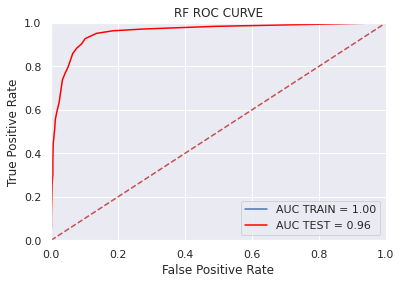

In [ ]:
plt.title('RF ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) : 
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

In [ ]:
feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( fm01_RF, feature_cols )

for i in vars_RF_flag :
    print( i )

('M_DEBTINC', 100)
('IMP_DEBTINC', 80)
('IMP_CLAGE', 44)
('IMP_DELINQ', 43)
('IMP_VALUE', 42)
('LOAN', 36)
('IMP_CLNO', 33)
('IMP_MORTDUE', 32)
('IMP_YOJ', 29)
('IMP_DEROG', 26)


#### Predict Loss Amount

In [ ]:
#build a model that predicts the loss amount
amt_m01_RF = RandomForestRegressor(n_estimators = 100, random_state=1)
amt_m01_RF = amt_m01_RF.fit( W_train, Z_train[TARGET_LOSS] )

Z_Pred_train = amt_m01_RF.predict(W_train)
Z_Pred_test = amt_m01_RF.predict(W_test)

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_LOSS], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_LOSS], Z_Pred_test))
RMSE_RF = RMSE_TEST

print("RF RMSE Train:", RMSE_TRAIN )
print("RF RMSE Test:", RMSE_TEST )

RF RMSE Train: 1224.2045361008875
RF RMSE Test: 3261.0178490237076


In [ ]:
feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( amt_m01_RF, feature_cols )

for i in vars_RF_amt :
    print( i )

('LOAN', 100)
('IMP_CLNO', 12)
('IMP_DEBTINC', 5)


## Gradient Boosting

#### Loan Default Probability

In [ ]:
fm01_GB = GradientBoostingClassifier( random_state=1 )
fm01_GB = fm01_GB.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_GB.predict(X_train)
Y_Pred_test = fm01_GB.predict(X_test)

print("GRADIENT BOOSTING\n")
print("Probability of default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

GRADIENT BOOSTING

Probability of default
Accuracy Train: 0.9236577181208053
Accuracy Test: 0.9035234899328859


In [ ]:
probs = fm01_GB.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_FLAG], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_GB.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_FLAG], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

fpr_GB = fpr_test
tpr_GB = tpr_test
auc_GB = roc_auc_test

In [ ]:
feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( fm01_GB, feature_cols )

for i in vars_GB_flag :
    print(i)

('M_DEBTINC', 100)
('IMP_DEBTINC', 29)
('IMP_DELINQ', 19)
('IMP_CLAGE', 13)


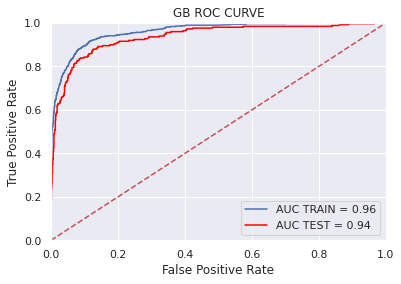

In [ ]:
plt.title('GB ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Predict Loss Amount

In [ ]:
amt_m01_GB = GradientBoostingRegressor(random_state=1)
amt_m01_GB = amt_m01_GB.fit( W_train, Z_train[TARGET_LOSS] )

Z_Pred_train = amt_m01_GB.predict(W_train)
Z_Pred_test = amt_m01_GB.predict(W_test)

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_LOSS], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_LOSS], Z_Pred_test))
RMSE_GB = RMSE_TEST

print("GB RMSE Train:", RMSE_TRAIN )
print("GB RMSE Test:", RMSE_TEST )

GB RMSE Train: 1218.1569933684325
GB RMSE Test: 2531.037788531138


In [ ]:
feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( amt_m01_GB, feature_cols )

for i in vars_GB_amt :
    print(i)

('LOAN', 100)
('IMP_CLNO', 14)
('IMP_DEBTINC', 5)
('M_DEBTINC', 5)


## ROC Curves

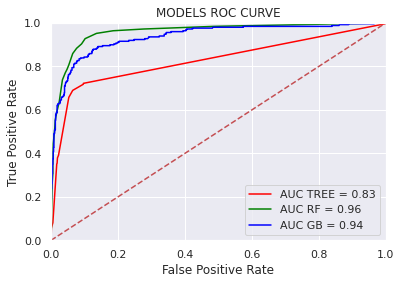

In [ ]:
plt.title('MODELS ROC CURVE')
plt.plot(fpr_tree, tpr_tree, 'b', label = 'AUC TREE = %0.2f' % auc_tree, color="red")
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC RF = %0.2f' % auc_RF, color="green")
plt.plot(fpr_GB, tpr_GB, 'b', label = 'AUC GB = %0.2f' % auc_GB, color="blue")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print("Root Mean Square Average For Loss Amounts")
print("TREE", RMSE_TREE)
print("RF", RMSE_RF)
print("GB", RMSE_GB)

Root Mean Square Average For Loss Amounts
TREE 5763.9837632219205
RF 3261.0178490237076
GB 2531.037788531138


## Bingo Bonus

#### Decision Tree Classifier - change max_depth

###### Let Python decide

Probability of loan default
Accuracy Train: 1.0
Accuracy Test: 0.875
Area under ROC curve for training data: 1.0
Area under ROC curve for testing data: 0.7917577911427008


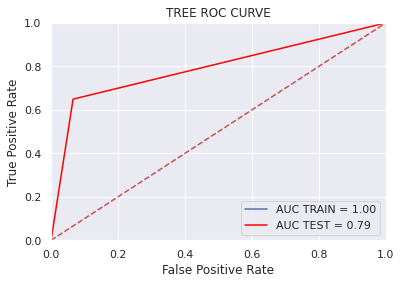

LOAN
z_IMP_REASON_HomeImp
z_IMP_REASON_MISSING
z_IMP_JOB_Mgr
z_IMP_JOB_Office
z_IMP_JOB_Other
z_IMP_JOB_ProfExe
z_IMP_JOB_Sales
z_IMP_JOB_Self
M_MORTDUE
IMP_MORTDUE
M_VALUE
IMP_VALUE
M_YOJ
IMP_YOJ
M_DEROG
IMP_DEROG
M_DELINQ
IMP_DELINQ
IMP_CLAGE
M_NINQ
IMP_NINQ
M_CLNO
IMP_CLNO
M_DEBTINC
IMP_DEBTINC


In [ ]:
fm01_Tree = tree.DecisionTreeClassifier() 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

#build an ROC curve
probs = fm01_Tree.predict_proba(X_train) #predict probability value
p1 = probs[:,1] #only want the probability of crashing the car
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_FLAG], p1) #give the data of what really happened and the p1 scores
roc_auc_train = metrics.auc(fpr_train, tpr_train) #find area under the ROC curve
print("Area under ROC curve for training data:", roc_auc_train)

probs = fm01_Tree.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_FLAG], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
print("Area under ROC curve for testing data:", roc_auc_test)

plt.title('TREE ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#seach variables for the model
def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list


vars_tree_flag = getTreeVars( fm01_Tree, feature_cols ) 

for i in vars_tree_flag :
    print(i)

###### Accuracy of different max_depth

In [ ]:
#max_depth = 2
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 2 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.8670302013422819
Accuracy Test: 0.8481543624161074


In [ ]:
#max_depth = 3
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 3 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.8873741610738255
Accuracy Test: 0.8825503355704698


In [ ]:
#max_depth = 4
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 4 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.8928271812080537
Accuracy Test: 0.886744966442953


In [ ]:
#max_depth = 5
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 5 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.8974412751677853
Accuracy Test: 0.886744966442953


In [ ]:
#max_depth = 6
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 6 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.902265100671141
Accuracy Test: 0.889261744966443


In [ ]:
#max_depth = 7
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 7 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.910234899328859
Accuracy Test: 0.8842281879194631


In [ ]:
#max_depth = 10
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 10 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.9305788590604027
Accuracy Test: 0.8800335570469798


#### Decision Tree & Random Forest Classifier - changing criterion = 'entropy'

In [ ]:
fm01_Tree = tree.DecisionTreeClassifier( criterion='entropy', max_depth=4 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.8886325503355704
Accuracy Test: 0.8825503355704698


In [ ]:
fm01_RF = RandomForestClassifier( criterion = 'entropy', n_estimators = 25, random_state=1 ) #n_estimators is the no. of decision trees
fm01_RF = fm01_RF.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_RF.predict(X_train)
Y_Pred_test = fm01_RF.predict(X_test)

print("RANDOM FOREST\n")
print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

RANDOM FOREST

Probability of loan default
Accuracy Train: 0.9991610738255033
Accuracy Test: 0.912751677852349


#### Decision Tree Classifier - change splitter = 'random'

In [ ]:
fm01_Tree = tree.DecisionTreeClassifier( splitter = 'random', max_depth=4 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))